In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn import datasets, linear_model, metrics
import _pickle as pickle
import time

In [2]:
import math
import numpy as np
import h5py
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.python.keras.layers as tfl
from tensorflow.python.framework import ops
#from cnn_utils import *
#from test_utils import summary, comparator
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tensorflow.keras import regularizers

#%matplotlib inline

In [3]:
with open("dataa", "rb") as input_file:
   df = pickle.load(input_file)

In [4]:
df['CH2']=[np.nan]*len(df)
for i in range(len(df)):
    if df['CH2_SHELA'].iloc[i]!=-99 :
        if df['CH2_SPIES'].iloc[i]!=-99 :
            df['CH2'].iloc[i]=(df['CH2_SPIES'].iloc[i]+df['CH2_SHELA'].iloc[i])/2
        else :
            df['CH2'].iloc[i]=df['CH2_SHELA'].iloc[i]
    elif df['CH2_SPIES'].iloc[i]!=-99 :
        df['CH2'].iloc[i]=df['CH2_SPIES'].iloc[i]
    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
df['CH1']=[np.nan]*len(df)
for i in range(len(df)):
    if df['CH1_SHELA'].iloc[i]!=-99 :
        if df['CH1_SPIES'].iloc[i]!=-99 :
            df['CH1'].iloc[i]=(df['CH1_SPIES'].iloc[i]+df['CH1_SHELA'].iloc[i])/2
        else :
            df['CH1'].iloc[i]=df['CH1_SHELA'].iloc[i]
    elif df['CH1_SPIES'].iloc[i]!=-99 :
        df['CH1'].iloc[i]=df['CH1_SPIES'].iloc[i]
    else :
        df['CH1'].iloc[i]=np.nan
    

In [6]:
dff=df[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT','REDSHIFT_ERR','ZWARNING']].dropna()

original : 6792 samples
after removing np.nans : 1729
removing samples with z_err>10% : 1686 
after removing ZWARNING!=0 :

In [7]:
dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT']]=dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT']].replace(-99,np.nan).dropna()

In [8]:
dff=dff.where(dff['REDSHIFT_ERR']<dff['REDSHIFT']*0.1).dropna()

In [9]:
dff=dff.where(dff['REDSHIFT']<1).where(dff['REDSHIFT']>0.3).dropna()

In [10]:
dff=dff.sample(frac=1)
X_data,y_data=dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2']],dff['REDSHIFT']

In [12]:
tf.keras.backend.set_floatx('float64')

In [13]:
%matplotlib notebook
#%matplotlib widget
import matplotlib.pyplot as plt

In [14]:
from tensorflow.python.keras.callbacks import LambdaCallback
import tensorflow.python.keras.backend as K
#from tf.optimizer import lbfgs_minimize

In [14]:
def Model1():
    model = tf.keras.Sequential([
        tfl.Dense(25,'tanh',input_shape=(12,)),
        tfl.Dense(1,'linear'),
        ])
    return model

In [14]:
def Model2(l2=1e-2):
    model = tf.keras.Sequential([
        tfl.Dense(25,'tanh',input_shape=(12,),kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(25,'tanh',kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(1,'linear',kernel_regularizer=regularizers.l2(l2)),
        ])
    return model

In [118]:
def Model3(l2,rate):
    model = tf.keras.Sequential([
        tfl.Dense(17,'relu',input_shape=(12,),kernel_regularizer=regularizers.l2(l2)),
        tfl.Dropout(rate),
        tfl.Dense(12,'relu',kernel_regularizer=regularizers.l2(l2)),
        tfl.Dropout(rate),
        tfl.Dense(1,'linear',kernel_regularizer=regularizers.l2(l2)),
        ])
    return model

In [15]:
def Model4(l2=1e-2):
    model = tf.keras.Sequential([
        tfl.Dense(17,'relu',input_shape=(12,),kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(12,'relu',kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(1,'linear',kernel_regularizer=regularizers.l2(l2)),
        ])
    return model

In [14]:
model1 = Model1()
# Print a summary for each layer
for layer in summary(model1):
    print(layer)

['Dense', (None, 25), 325, 'tanh']
['Dense', (None, 1), 26, 'linear']


In [16]:
inscaler = MinMaxScaler((-1,1))
ouscaler = MinMaxScaler()
Xs_data  = inscaler.fit_transform(X_data)
ys_data  = ouscaler.fit_transform(np.array(y_data).reshape(-1,1))

In [23]:
def score_m(ys_data, pred):
    #zs=K.std(tf.math.divide((pred-ys_data),(1+ys_data)))
    return K.mean(K.abs(pred-ys_data))
loss_m  = make_scorer(score_m, greater_is_better=False)
def score_dz(ys_data, pred):
    #zs=K.std(tf.math.divide(K.abs(pred-ys_data),(1+ys_data)))
    return K.mean(tf.math.divide(K.abs(pred-ys_data),(1+ys_data)))
loss_dz  = make_scorer(score_dz, greater_is_better=False)

In [17]:
def score(ys_data,pred):
    return K.mean(K.abs((pred-ys_data)/(1+ys_data)))

In [18]:
def plot_his(history,n='n'):
    if n=='n':
        N=len(history)
        hisloss=np.sum([history[i].history['loss'] for i in range(N)],axis=0)/N
        hisval=np.sum([history[i].history['val_loss'] for i in range(N)],axis=0)/N
    else :
        hisloss=history[n].history['loss']
        hisval=history[n].history['val_loss']
    plt.figure()
    plt.plot(hisloss)
    plt.plot(hisval)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [19]:
def return_his(history,n='n'):
    if n=='n':
        N=len(history)
        hisloss=np.sum([history[i].history['loss'] for i in range(N)],axis=0)/N
        hisval=np.sum([history[i].history['val_loss'] for i in range(N)],axis=0)/N
    else :
        hisloss=history[n].history['loss']
        hisval=history[n].history['val_loss']
    return (np.as_array(hisloss),np.as_array(hisval))

In [29]:
n=4
N=int(len(Xs_data)/n)
history=[]
for lr in [0.004]:
    print('\n')
    for i in range(3):
        print(lr)
        history4=[]
        dz_val,dz_train=[],[]
        start=time.time()
        for i in range(n):
                Xs_train,y_train=list(Xs_data.copy()),list(y_data.copy())
                del Xs_train[i*N:i*N+N]
                del y_train[i*N:i*N+N]
                Xs_val,y_val=Xs_data[i*N:i*N+N],y_data[i*N:i*N+N]
                ouscaler= MinMaxScaler()
                ys_train= ouscaler.fit_transform(np.array(y_train).reshape(-1,1))
                ys_val  = ouscaler.transform(np.array(y_val).reshape(-1,1))
                Xs_train,Xs_val,ys_train,ys_val,y_val,y_train=np.array(Xs_train),np.array(Xs_val),np.array(ys_train),np.array(ys_val),np.array(y_val),np.array(y_train)
                model4 = Model4(0)
                optimizer=tf.keras.optimizers.Adam(lr)
                model4.compile(optimizer=optimizer,loss=score)
                h=model4.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=1000,verbose=0)
                pred_train=ouscaler.inverse_transform(model4.predict(Xs_train)).reshape(len(y_train))
                pred_val=ouscaler.inverse_transform(model4.predict(Xs_val)).reshape(len(y_val))
                dz_val.append(np.array((pred_val-y_val)/(1+y_val)))
                dz_train.append(np.array((pred_train-y_train)/(1+y_train)))
                #print('std train:',np.std(dz_train[-1]),'\nmean train:',np.mean(dz_train[-1]))
                print('std val:',np.std(dz_val[-1]),'\nmean val:',np.mean(dz_val[-1]))
                history4.append(h)
        stop=time.time()
        print(f"Training time: {stop - start}s")
        trainstd,trainmean,valstd,valmean=np.mean([np.std(dz_train[i]) for i in range(n)]),np.mean(np.abs([np.mean(dz_train[i]) for i in range(n)])),np.mean([np.std(dz_val[i]) for i in range(n)]),np.mean(np.abs([np.mean(dz_val[i]) for i in range(n)]))
        print('train : \nstd :',trainstd,'\nmean :',trainmean)
        print('val   : \nstd :',valstd,'\nmean :',valmean)
        N=len(history4)
        trainloss=np.sum([history4[i].history['loss'] for i in range(N)],axis=0)[-1]/N
        valloss=np.sum([history4[i].history['val_loss'] for i in range(N)],axis=0)[-1]/N
        print('trainloss-',trainloss,'valloss-',valloss)
        history.append(history4)
        #pickle.dump(return_his(history4), open(str(l2)+'_11_10_2.pkl', 'wb'))
#model4.save('model_1_17_10/my_model')



0.004
std val: 0.06446916393391867 
mean val: 0.005826068290310233
std val: 0.05371350868504198 
mean val: -0.013649727224771206
std val: 0.058912559462293915 
mean val: 0.019690294948937453
std val: 0.0621353499008955 
mean val: -0.005367147587423694
Training time: 92.51827549934387s
train : 
std : 0.03093628900810609 
mean : 0.005934302472667682
val   : 
std : 0.05980764549553751 
mean : 0.011133309512860647
trainloss- 0.034071949438511315 valloss- 0.06867470374280538
0.004
std val: 0.023270240751382308 
mean val: 0.005212444348868817
std val: 0.013062032369517777 
mean val: 0.016150569273607425
std val: 0.015383173989225118 
mean val: -0.024412406820124966
std val: 0.040224067166021234 
mean val: 0.01849255013346804
Training time: 96.206463098526s
train : 
std : 0.034259808125285396 
mean : 0.00456304956010216
val   : 
std : 0.02298487856903661 
mean : 0.01606699264401731
trainloss- 0.037244932760729335 valloss- 0.04106153082102537
0.004
std val: 0.013188673709078553 
mean val: 0.

In [124]:
print(model4.layers[0].get_weights())

[array([[ 0.343371  , -0.25934067,  0.3625366 , -0.1197594 , -0.16623809,
         0.23760216,  0.56641616, -0.21173647,  0.08617085, -0.40512928,
        -0.40998278,  0.11418894,  0.25480092,  0.06162395,  0.01076687,
        -0.07695771, -0.12898871],
       [-0.11911541,  0.1273042 , -0.19746575,  0.16838746,  0.69218131,
         0.06797073,  0.50552155, -0.80398675, -0.47753962,  0.6067717 ,
         0.04912715,  0.54936784,  0.08694003,  0.53684956, -0.16363391,
        -1.03845925, -0.62777671],
       [ 0.16385146, -0.39664492,  0.28578696, -0.15396993,  0.32381282,
        -0.03158334,  0.18152491, -0.5436214 , -0.47035147, -0.06794106,
        -0.48371287, -0.39106784,  0.04316912,  0.07638262,  0.24959227,
         0.56065044,  0.34631058],
       [-0.15262826,  0.34521276,  0.2600266 ,  0.23772577, -0.13860626,
        -0.073828  ,  0.33544715, -0.20427198, -0.41640443,  0.09729311,
        -0.25100982, -0.38234869, -0.09483531,  0.12185964, -0.06478684,
         0.2875618

<IPython.core.display.Javascript object>


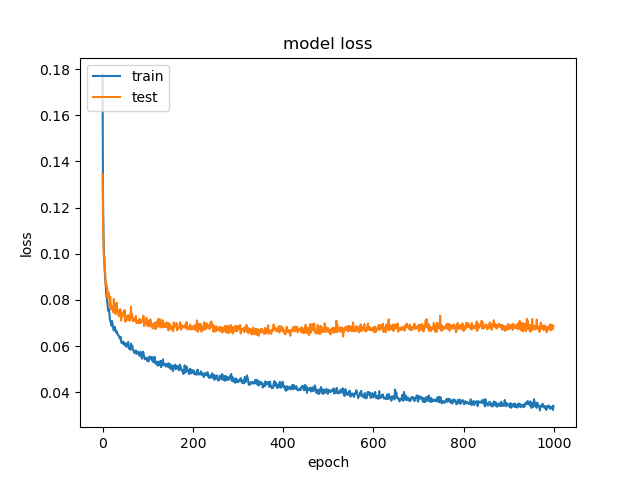

In [33]:
history4=history[0]
hisloss=np.sum([history4[i].history['loss'] for i in range(4)],axis=0)/4
hisval=np.sum([history4[i].history['val_loss'] for i in range(4)],axis=0)/4
plt.figure()
plt.plot(hisloss)
plt.plot(hisval)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

<IPython.core.display.Javascript object>


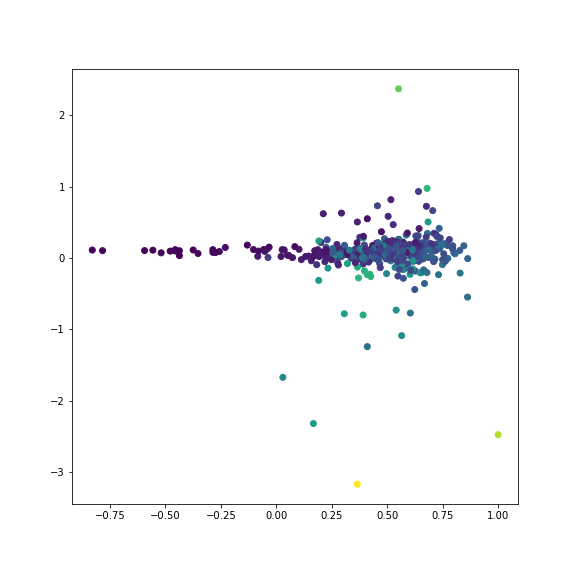

In [164]:
plt.figure(figsize=(8,8))
plt.scatter(Xs_val[:,5],pred_val-y_val,c=y_val)
#plt.colorbar()
#plt.plot(np.linspace(min(y_val),max(y_val),100),np.linspace(min(y_val),max(y_val),100))

<IPython.core.display.Javascript object>


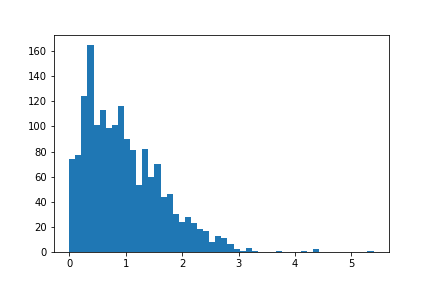

(array([ 74.,  77., 124., 165., 101., 113.,  99., 101., 116.,  90.,  81.,
         53.,  82.,  60.,  70.,  44.,  46.,  30.,  24.,  28.,  23.,  18.,
         17.,   8.,  13.,  11.,   6.,   2.,   1.,   3.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-1.57083894e-04,  1.07670076e-01,  2.15497240e-01,  3.23324412e-01,
         4.31151569e-01,  5.38978755e-01,  6.46805882e-01,  7.54633069e-01,
         8.62460196e-01,  9.70287383e-01,  1.07811451e+00,  1.18594170e+00,
         1.29376888e+00,  1.40159607e+00,  1.50942314e+00,  1.61725032e+00,
         1.72507751e+00,  1.83290470e+00,  1.94073188e+00,  2.04855895e+00,
         2.15638614e+00,  2.26421332e+00,  2.37204051e+00,  2.47986770e+00,
         2.58769488e+00,  2.69552207e+00,  2.80334902e+00,  2.91117620e+00,
         3.01900339e+00,  3.12683058e+00,  3.23465776e+00,  3.34248495e+00,
         3.45031214e+00,  3.55813932e+00,  3.66596

In [159]:
plt.figure()
plt.hist(y_data,bins=50)

In [168]:
y_data.where(y_data>0.3).where(y_data<1).dropna()

1579    0.412714
6147    0.301092
2907    0.612088
773     0.936666
2744    0.328064
          ...   
1844    0.658222
1049    0.483661
5362    0.919000
461     0.960000
2171    0.577779
Name: REDSHIFT, Length: 742, dtype: float32

In [3]:
history4

NameError: name 'history4' is not defined

<IPython.core.display.Javascript object>


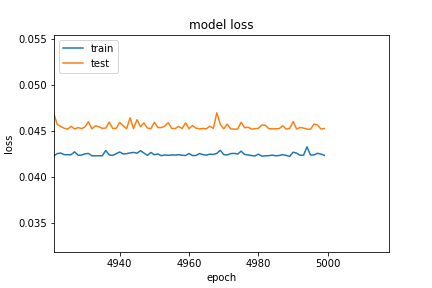

In [72]:
plt.figure()
plt.plot(history1[0].history['loss'])
plt.plot(history1[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
N=int(len(Xs_data)/4)
history2=[]
dz=[]
for i in range(4):
    Xs_train,ys_train=list(Xs_data.copy()),list(ys_data.copy())
    del Xs_train[i*N:i*N+N]
    del ys_train[i*N:i*N+N]
    Xs_val,ys_val=Xs_data[i*N:i*N+N],ys_data[i*N:i*N+N]
    Xs_train,ys_train=np.array(Xs_train),np.array(ys_train)
    model2 = Model1()
    model2.compile(optimizer=optimizer,loss=scoree)
    h=model2.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=500)
    pred=model2.predict(Xs_val).reshape(len(ys_val))
    dz.append(np.array((-ys_val.reshape(len(ys_val))+pred)/(1+ys_val.reshape(len(ys_val)))))
    history2.append(h)

Epoch 1/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0892 - val_loss: 0.0654
Epoch 2/500
40/40 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0774
Epoch 3/500
40/40 [==============================] - 0s 950us/step - loss: 0.0668 - val_loss: 0.0632
Epoch 4/500
40/40 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0665
Epoch 5/500
40/40 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0649
Epoch 6/500
40/40 [==============================] - 0s 965us/step - loss: 0.0636 - val_loss: 0.0645
Epoch 7/500
40/40 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0681
Epoch 8/500
40/40 [==============================] - 0s 937us/step - loss: 0.0629 - val_loss: 0.0676
Epoch 9/500
40/40 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0637
Epoch 10/500
40/40 [==============================] - 0s 920us/step - loss: 0.0606 - val_loss: 0.0633
E

In [44]:
hisval[-1],hisval[100]

(0.05600255280910081, 0.058928284864881546)

In [47]:
np.mean([np.std(dz[i]) for i in range(4)]),np.mean([np.mean(np.abs(dz[i])) for i in range(4)])

(0.06434764647217828, 0.04477473767127335)

<IPython.core.display.Javascript object>


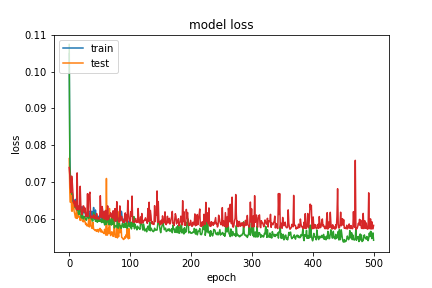

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [102]:
N=int(len(Xs_data)/4)
history3=[]
dz3=[]
for i in range(4):
    Xs_train,ys_train=list(Xs_data.copy()),list(ys_data.copy())
    del Xs_train[i*N:i*N+N]
    del ys_train[i*N:i*N+N]
    Xs_val,ys_val=Xs_data[i*N:i*N+N],ys_data[i*N:i*N+N]
    Xs_train,ys_train=np.array(Xs_train),np.array(ys_train)
    model3 = Model2()
    optimizer=tf.keras.optimizers.Adam(0.00002)
    model3.compile(optimizer=optimizer,loss='binary_crossentropy')
    h=model3.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=5000)
    pred=model3.predict(Xs_val).reshape(len(ys_val))
    dz3.append(np.array(np.abs((-ys_val.reshape(len(ys_val))+pred)/(1+ys_val.reshape(len(ys_val))))))
    history3.append(h)

Epoch 1/5000
40/40 [==============================] - 0s 3ms/step - loss: 2.2167 - val_loss: 2.2017
Epoch 2/5000
40/40 [==============================] - 0s 1ms/step - loss: 2.2080 - val_loss: 2.1937
Epoch 3/5000
40/40 [==============================] - 0s 1ms/step - loss: 2.1998 - val_loss: 2.1855
Epoch 4/5000
40/40 [==============================] - 0s 993us/step - loss: 2.1915 - val_loss: 2.1783
Epoch 5/5000
40/40 [==============================] - 0s 1ms/step - loss: 2.1842 - val_loss: 2.1709
Epoch 6/5000
40/40 [==============================] - 0s 995us/step - loss: 2.1769 - val_loss: 2.1635
Epoch 7/5000
40/40 [==============================] - 0s 984us/step - loss: 2.1694 - val_loss: 2.1560
Epoch 8/5000
40/40 [==============================] - 0s 984us/step - loss: 2.1620 - val_loss: 2.1483
Epoch 9/5000
40/40 [==============================] - 0s 968us/step - loss: 2.1543 - val_loss: 2.1407
Epoch 10/5000
40/40 [==============================] - 0s 962us/step - loss: 2.1465 - val_

In [110]:
print('std :',np.mean([np.std(dz3[i]) for i in range(4)]),'\nmean :',np.mean([np.mean(dz3[i]) for i in range(4)]))

std : 0.05498334603812505 
mean : 0.08389924000788519


<IPython.core.display.Javascript object>


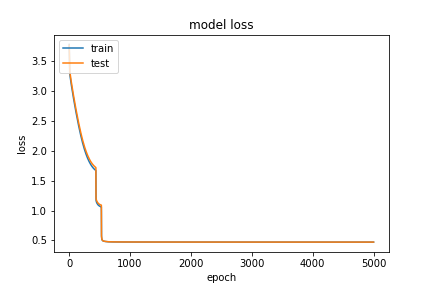

In [116]:
plot_his(history3)

In [95]:
N=int(len(Xs_data)/4)
history4=[]
dz_val,dz_train=[],[]
for i in range(4):
    print(i)
    Xs_train,y_train=list(Xs_data.copy()),list(y_data.copy())
    del Xs_train[i*N:i*N+N]
    del y_train[i*N:i*N+N]
    Xs_val,y_val=Xs_data[i*N:i*N+N],y_data[i*N:i*N+N]

    ouscaler= MinMaxScaler((-1,1))
    ys_train= ouscaler.fit_transform(np.array(y_train).reshape(-1,1))
    ys_val  = ouscaler.transform(np.array(y_val).reshape(-1,1))

    Xs_train,Xs_val,ys_train,ys_val,y_val,y_train=np.array(Xs_train),np.array(Xs_val),np.array(ys_train),np.array(ys_val),np.array(y_val),np.array(y_train)

    model4 = Model4(1e-2)
    optimizer=tf.keras.optimizers.Adam(0.0001)
    model4.compile(optimizer=optimizer,loss='MAE')
    h=model4.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=3,verbose=0)
    
    pred_train=ouscaler.inverse_transform(model4.predict(Xs_train)).reshape(len(y_train))
    pred_val=ouscaler.inverse_transform(model4.predict(Xs_val)).reshape(len(y_val))
    dz_val.append(np.array((pred_val-y_val)/(1+y_val)))
    dz_train.append(np.array((pred_train-y_train)/(1+y_train)))
    
    #print('std train:',np.std(dz_train[-1]),'\nmean train:',np.mean(dz_train[-1]))
    #print('std val:',np.std(dz_val[-1]),'\nmean val:',np.mean(dz_val[-1]))
    history4.append(h)
N=len(history4)
trainloss=np.sum([history4[i].history['loss'] for i in range(N)],axis=0)[-1]/N
valloss=np.sum([history4[i].history['val_loss'] for i in range(N)],axis=0)[-1]/N

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KeyboardInterrupt: 

In [100]:
print('train : \nstd :',np.mean([np.std(dz_train[i]) for i in range(4)]),'\nmean :',np.mean(np.abs([np.mean(dz_train[i]) for i in range(4)])))
print('val   : \nstd :',np.mean([np.std(dz_val[i]) for i in range(4)]),'\nmean :',np.mean(np.abs([np.mean(dz_val[i]) for i in range(4)])))

train : 
std : 0.2095645043122963 
mean : 0.042518663552138236
val   : 
std : 0.21079592780911782 
mean : 0.04301704799386836


<IPython.core.display.Javascript object>


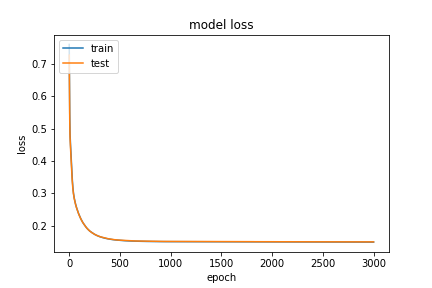

In [90]:
plot_his(history4)

In [92]:
model4.layers[0].get_weights()

[array([[ 3.29287103e-02,  1.49528335e-01, -1.14579416e-01,
         -1.11590462e-02, -7.43870292e-02,  7.76705746e-03,
         -3.76435931e-01, -4.58045409e-02, -2.53173776e-01,
          4.31299747e-02,  1.49785889e-02, -4.93828856e-06],
        [-2.14446706e-02, -9.37088967e-02,  7.22044655e-02,
          7.19834234e-03,  4.85647636e-02, -4.98014065e-03,
          1.08913875e-01,  2.99286538e-02,  1.65016953e-01,
         -2.78839798e-02, -9.70619029e-03, -3.77203590e-07],
        [ 9.09850849e-03,  4.84763229e-02, -3.63243441e-02,
         -3.01778546e-03, -2.11297606e-02,  2.10266695e-03,
         -1.63547004e-01, -1.26662220e-02, -8.32380304e-02,
          1.23439553e-02,  4.04989021e-03, -4.47067453e-06],
        [ 2.16012432e-02,  1.03435183e-01, -7.87064977e-02,
         -7.24475135e-03, -4.93724444e-02,  5.03877865e-03,
         -2.69930915e-01, -3.00984299e-02, -1.76448388e-01,
          2.86147928e-02,  9.73566826e-03, -9.04118900e-06],
        [-1.56085158e-02, -7.3456305

In [99]:
N=int(len(Xs_data)/4)
history4=[]
dz_val,dz_train=[],[]
for i in range(4):
    Xs_train,y_train=list(Xs_data.copy()),list(y_data.copy())
    del Xs_train[i*N:i*N+N]
    del y_train[i*N:i*N+N]
    Xs_val,y_val=Xs_data[i*N:i*N+N],y_data[i*N:i*N+N]

    ouscaler= MinMaxScaler()
    ys_train= ouscaler.fit_transform(np.array(y_train).reshape(-1,1))
    ys_val  = ouscaler.transform(np.array(y_val).reshape(-1,1))

    Xs_train,Xs_val,ys_train,ys_val,y_val,y_train=np.array(Xs_train),np.array(Xs_val),np.array(ys_train),np.array(ys_val),np.array(y_val),np.array(y_train)

    model4 = Model4(1e-2)
    optimizer=tf.keras.optimizers.Adam(0.0001)
    model4.compile(optimizer=optimizer,loss='binary_crossentropy')
    h=model4.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=3000,verbose=0)
    
    pred_train=ouscaler.inverse_transform(model4.predict(Xs_train)).reshape(len(y_train))
    pred_val=ouscaler.inverse_transform(model4.predict(Xs_val)).reshape(len(y_val))
    dz_val.append(np.array((pred_val-y_val)/(1+y_val)))
    dz_train.append(np.array((pred_train-y_train)/(1+y_train)))
    print('std train:',np.std(dz_train[-1]),'\nmean train:',np.mean(dz_train[-1]))
    print('std val:',np.std(dz_val[-1]),'\nmean val:',np.mean(dz_val[-1]))
    history4.append(h)

std train: 0.2066195105248868 
mean train: 0.043400745449305764
std val: 0.2183898357063497 
mean val: 0.049997505698985
std train: 0.2104307791310651 
mean train: 0.045692299179413996
std val: 0.20991297914416956 
mean val: 0.050433964328169795
std train: 0.2119332353480524 
mean train: 0.04076702353440501
std val: 0.2075856721180537 
mean val: 0.045632976792646364
std train: 0.20927449224518088 
mean train: 0.04021458604542819
std val: 0.20729522426789831 
mean val: 0.02600374515567228


In [ ]:
N=int(len(Xs_data)/4)
history6=[]
dz6=[]
for i in range(4):
    Xs_train,ys_train=list(Xs_data.copy()),list(ys_data.copy())
    del Xs_train[i*N:i*N+N]
    del ys_train[i*N:i*N+N]
    Xs_val,ys_val=Xs_data[i*N:i*N+N],ys_data[i*N:i*N+N]
    Xs_train,ys_train=np.array(Xs_train),np.array(ys_train)
    model6 = Model1()
    print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: weights.append([model6.layers[0].get_weights(),model6.layers[1].get_weights()]))
    optimizer=tf.keras.optimizers.SGD()
    model6.compile(optimizer=optimizer,loss='mean_absolute_error')
    h=model6.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=4000,callbacks = [print_weights])
    pred=ouscaler.inverse_transform(model6.predict(Xs_val))
    y_val=ouscaler.inverse_transform(ys_val)
    dz6.append(np.array(np.abs((pred-y_val)/(1+y_val))))
    history6.append(h)

Epoch 1/4000
40/40 [==============================] - 0s 4ms/step - loss: 0.1470 - val_loss: 0.1377
Epoch 2/4000
40/40 [==============================] - 0s 831us/step - loss: 0.1335 - val_loss: 0.1245
Epoch 3/4000
40/40 [==============================] - 0s 858us/step - loss: 0.1241 - val_loss: 0.1215
Epoch 4/4000
40/40 [==============================] - 0s 840us/step - loss: 0.1136 - val_loss: 0.1066
Epoch 5/4000
40/40 [==============================] - 0s 846us/step - loss: 0.1068 - val_loss: 0.1032
Epoch 6/4000
40/40 [==============================] - 0s 862us/step - loss: 0.0977 - val_loss: 0.0902
Epoch 7/4000
40/40 [==============================] - 0s 884us/step - loss: 0.0918 - val_loss: 0.0921
Epoch 8/4000
40/40 [==============================] - 0s 861us/step - loss: 0.0860 - val_loss: 0.0884
Epoch 9/4000
40/40 [==============================] - 0s 888us/step - loss: 0.0814 - val_loss: 0.0816
Epoch 10/4000
40/40 [==============================] - 0s 866us/step - loss: 0.0785 

In [40]:
plot_his(history6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
model6.get_weights()

[array([[-5.19358092e-01, -1.03660126e-01, -3.13818452e-01,
         -2.81610152e-02,  2.61328868e-01,  3.79349681e-01,
          2.10737460e-01,  2.50994608e-02,  4.84040373e-01,
         -2.58632419e-01,  2.10909015e-02,  1.76002065e-01,
         -2.34132588e-01,  1.37978004e-01,  4.01525451e-01,
          7.63986262e-02, -2.38478069e-01,  4.68545318e-01,
          1.66985279e-01,  3.98085303e-01, -1.69773221e-01,
          1.80107453e-01,  7.84856338e-02,  3.13706013e-01,
         -2.85524172e-01],
        [ 2.51941562e-01,  5.99671605e-01, -2.05341193e-01,
         -1.74945085e-01, -2.66251651e-01, -1.24685588e-01,
         -1.64157580e-01,  7.10140852e-02,  1.23563048e-01,
          1.85897364e-01, -8.63483029e-02, -3.43903349e-01,
          2.04318118e-02,  2.11422766e-01, -1.07776998e-01,
         -5.18544910e-02,  3.51969155e-01, -2.93015590e-02,
         -1.27443969e-01, -2.43613566e-01,  2.07561828e-01,
         -5.96044507e-02, -2.77034158e-01, -1.77811473e-01,
          5.1

In [63]:
bias=np.array([weights[i][-1][-1][0] for i in range(4000)])

In [65]:
plt.figure()
plt.plot(bias)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [78]:
def Model2():
    model = tf.keras.Sequential([
        tfl.Dense(18,'tanh',input_shape=(12,)),
        tfl.Dense(24,'tanh'),
        tfl.Dense(12,'tanh'),
        tfl.Dense(1),
        ])
    return model

In [79]:
model2 = Model2()
# Print a summary for each layer
for layer in summary(model2):
    print(layer)

['Dense', (None, 18), 234, 'tanh']
['Dense', (None, 24), 456, 'tanh']
['Dense', (None, 12), 300, 'tanh']
['Dense', (None, 1), 13, 'linear']


In [80]:
model2.compile(optimizer='adam',loss='mean_squared_error')

In [81]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 18)                234       
_________________________________________________________________
dense_19 (Dense)             (None, 24)                456       
_________________________________________________________________
dense_20 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 13        
Total params: 1,003
Trainable params: 1,003
Non-trainable params: 0
_________________________________________________________________


In [82]:
model2.fit(X_data, ys_data, epochs=100, batch_size=500)

Epoch 1/100
4/4 [==============================] - 0s 1ms/step - loss: 0.0259
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 3/100
4/4 [==============================] - 0s 943us/step - loss: 0.0168
Epoch 4/100
4/4 [==============================] - 0s 980us/step - loss: 0.0128
Epoch 5/100
4/4 [==============================] - 0s 981us/step - loss: 0.0134
Epoch 6/100
4/4 [==============================] - 0s 935us/step - loss: 0.0120
Epoch 7/100
4/4 [==============================] - 0s 935us/step - loss: 0.0118
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0116
Epoch 9/100
4/4 [==============================] - 0s 927us/step - loss: 0.0111
Epoch 10/100
4/4 [==============================] - 0s 951us/step - loss: 0.0113
Epoch 11/100
4/4 [==============================] - 0s 994us/step - loss: 0.0111
Epoch 12/100
4/4 [==============================] - 0s 922us/step - loss: 0.0110
Epoch 13/100
4/4 [========================

In [83]:
pred2=happy_model.predict(X_data).reshape(1686)

In [84]:
np.std((-ys_data.reshape(1686)+pred2)/(1+ys_data.reshape(1686)))

0.07418019303386438